In [1]:
#This script will compare the ambient temperature in Oxford 
#with the inside temperature of the RadCam to find the 
#temperature difference during the operating hours of the boiler.

import os
import xlrd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
import seaborn as sns

In [2]:
#import the inside temperatures

# citation for example data: www.renewables.ninja and Gelaro et al. (2017), doi: 10.1175/JCLI-D-16-0758.1

#temperatures in Oxford in 2019
df = pd.read_csv("C:\\Users\\Michael\\OneDrive - Nexus365\\LEO\\3YP Coding\\Degree Days\\ExampleDataA.csv",)
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M') #ensure datetime is enabled
df = df.sort_values(by="DateTime") #just formatting
df.set_index('DateTime') #set the dates as the index


#do the same for outside temperature (hourly scale)

#temperatures in Swindon in 2019
dfa = pd.read_csv("C:\\Users\\Michael\\OneDrive - Nexus365\\LEO\\3YP Coding\\Degree Days\\ExampleDataB.csv",)
dfa['DateTime'] = pd.to_datetime(dfa['DateTime'], format='%d/%m/%Y %H:%M')
dfa = dfa.sort_values(by="DateTime")
dfa.set_index('DateTime')


,temp
DateTime,
2019-01-01 00:00:00,5.702
2019-01-01 01:00:00,5.718
2019-01-01 02:00:00,5.461
2019-01-01 03:00:00,5.482
2019-01-01 04:00:00,5.685
...,...
2019-12-31 19:00:00,6.946
2019-12-31 20:00:00,6.506
2019-12-31 21:00:00,6.225


In [3]:
#add columns with different date information for RadCam
df['Month'] = df['DateTime'].dt.month_name()
df['Day'] = df['DateTime'].dt.day_name()
df['Date']=df['DateTime'].dt.date
df['Hour']=df['DateTime'].dt.hour

#group the data into data and hour columns (averages the 5 minute intervals over each hour)
df1 = df.groupby(['Date', 'Hour'],sort=False).agg(['mean'])
df1.columns=df1.columns.droplevel(0)
df1.reset_index(inplace=True)


#and repeat for outside temperature
dfa['Month'] = dfa['DateTime'].dt.month_name()
dfa['Day'] = dfa['DateTime'].dt.day_name()
dfa['Date']=dfa['DateTime'].dt.date
dfa['Hour']=dfa['DateTime'].dt.hour

dfa1 = dfa.groupby(['Date', 'Hour'],sort=False).agg(['mean'])
dfa1.columns=dfa1.columns.droplevel(0)
dfa1.reset_index(inplace=True)

Text(0.5, 1.0, 'RadCam LRR Temperature (°C)')

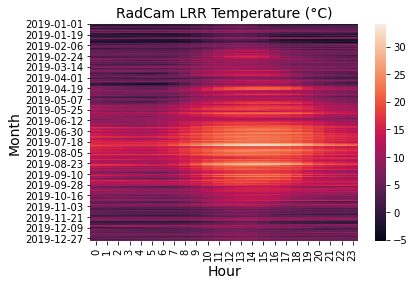

In [4]:
#plot the heatmap for RadCam
heatmap_data = pd.pivot_table(df1, values='mean', index=['Date'], columns='Hour')
sns.heatmap(heatmap_data)
plt.xlabel("Hour", size=14)
plt.ylabel("Month", size=14)
plt.title("RadCam LRR Temperature (°C)", size=14)

Text(0.5, 1.0, 'Oxford Temperature (°C)')

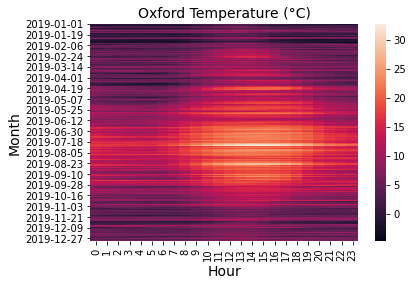

In [5]:
#plot the heatmap for Outside Temps
heatmap_data_a = pd.pivot_table(dfa1, values='mean', index=['Date'], columns='Hour')
sns.heatmap(heatmap_data_a)
plt.xlabel("Hour", size=14)
plt.ylabel("Month", size=14)
plt.title("Oxford Temperature (°C)", size=14)

In [6]:
#create a dataframe 'df3' that has the temperature difference between the building and outside 

test_data = df1['mean'] - dfa1['mean'] #subtract oxford air temp from RadCam Temp

data = [df1['Date'],df1['Hour'],test_data] 
headers = ["Date","Hour","mean"]
df3 = pd.concat(data, axis=1, keys=headers) #puts together data and headers
df3['Day'] = dfa['DateTime'].dt.day_name()  #adds the days of the week 



Text(0.5, 1.0, 'Temperature difference between RadCam and Outside (°C)')

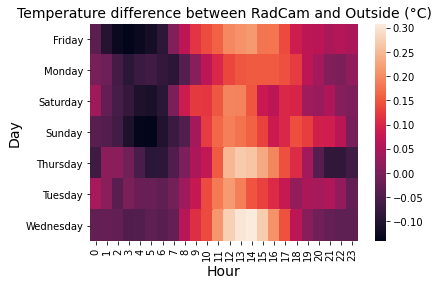

In [7]:
#print a heatmap of the temperature difference
heatmap_test = pd.pivot_table(df3, values='mean', index=['Day'], columns='Hour')
sns.heatmap(heatmap_test)
plt.xlabel("Hour", size=14)
plt.ylabel("Day", size=14)
plt.title("Temperature difference between RadCam and Outside (°C)", size=14)

In [8]:
#now apply masks to extract the boiler operating hours 
#and when the inside is hotter than the outside

mask1 = df3.loc[(df3['Hour'] > 6.9) & (df3['Hour'] < 21)] #weekday heating times

mask2 = mask1.mask((df3['Hour'] < 9) & (df3['Day'] == 'Saturday'))
mask3 = mask2.mask((df3['Hour'] > 15) & (df3['Day'] == 'Saturday')) #these are Saturday heating times

mask4 = mask3.mask((df3['Hour'] < 10) & (df3['Day'] == 'Sunday'))
mask5 = mask4.mask((df3['Hour'] > 16) & (df3['Day'] == 'Sunday')) #these are the Sunday heating times

mask6 = mask5.mask(df3['mean']<0) #only considers when the inside is hotter than the outside

final = mask6

Text(0.5, 1.0, 'Temperature difference between RadCam and Outside (°C)')

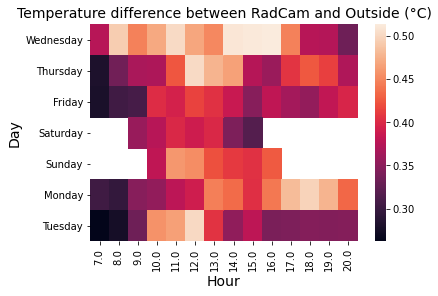

In [9]:


heatmap_data_final = pd.pivot_table(final, values='mean', index=['Day'], columns='Hour')

#need to ensure days of the week show in the right order


a = heatmap_data_final.index.values
rows = list(a)
rows.insert(0, rows.pop(rows.index('Wednesday')))
rows.insert(1, rows.pop(rows.index('Thursday')))
rows.insert(2, rows.pop(rows.index('Friday')))
rows.insert(3, rows.pop(rows.index('Saturday')))
rows.insert(4, rows.pop(rows.index('Sunday')))
rows.insert(5, rows.pop(rows.index('Monday')))
heatmap_data_final = heatmap_data_final.loc[rows, :]


#now plot the week vs hour average temperature difference
sns.heatmap(heatmap_data_final)
plt.xlabel("Hour", size=14)
plt.ylabel("Day", size=14)
plt.title("Temperature difference between RadCam and Outside (°C)", size=14)

Text(0.5, 1.0, 'Temperature difference between RadCam and Outside (°C)')

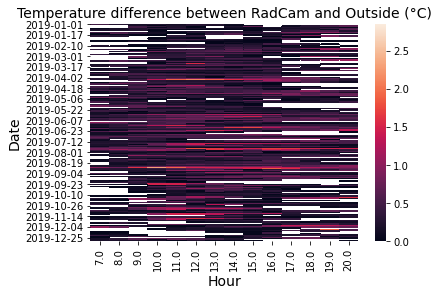

In [10]:
#the full uncompressed temperature profile is plotted here
#we sum all the elements of this to find the total degree hours of the RadCam
#over this time period
heatmap_data_final = pd.pivot_table(final, values='mean', index=['Date'], columns='Hour')
sns.heatmap(heatmap_data_final)
plt.xlabel("Hour", size=14)
plt.ylabel("Date", size=14)
plt.title("Temperature difference between RadCam and Outside (°C)", size=14)

In [13]:
#calculates degree hours and degree days
degree_hours = round(final['mean'].sum())
degree_days = round(degree_hours/12)
print("There are", degree_hours, "degree hours over this time period." )
print("This equates to", degree_days, "degree days in 2019.")

There are 1089 degree hours over this time period.
This equates to 91 degree days in 2019.
